In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [4]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'
# TARGET_VAR =      'VCI3M'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'features/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


# Read in the data

In [5]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [6]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

# bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
# lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

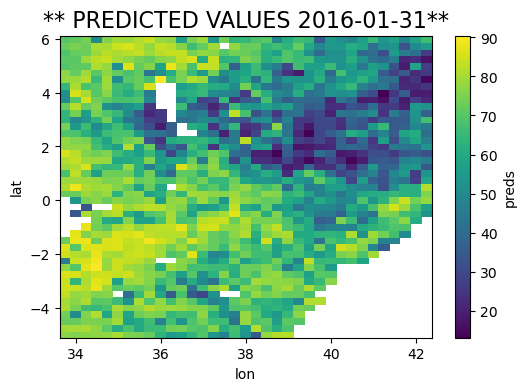

In [7]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

### Load in the models

In [8]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

10

In [9]:
dynamic_ds = ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)])

static_vars_to_include = [
    v
    for v in static_ds.data_vars
    if all([ign_v not in v for ign_v in ealstm.ignore_vars])
]
static = static_ds[static_vars_to_include]

### Check the input data

In [10]:
from matplotlib import cm


def get_unique_value_counts_xarray(da: xr.Dataset, dropna: bool = True) -> Dict[int, int]:
    """ NOTE only works for int-like data! (e.g. whole floats)"""
    if dropna:
        data = da.values.flatten()
        data = data[~np.isnan(data)]
    else:
        data = da.values.flatten()
    counts = np.bincount(data.astype(int))
    ii = np.nonzero(counts)[0]
    
    return dict(zip(ii, counts[ii]))


def plot_unique_value_counts(da: xr.DataArray, ax: Optional = None, label: bool = True) -> plt.Axes:
    """Plot colored histogram of integer values 0-100"""
    # create count of unique values
    counts = get_unique_value_counts_xarray(da)
    d = pd.DataFrame(
        counts, index=[0]
    )

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    n_unique_vals = len(counts)
    viridis = cm.get_cmap('viridis', n_unique_vals)(np.linspace(0, 1, n_unique_vals))
    g = sns.barplot(data=d, palette=viridis, ax=ax)
    ax.set_ylabel('Number of Instances')
    ax.set_title('Count of Unique Values')
    
    if label:
        for p in g.patches:
            g.annotate(
                format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points'
            )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

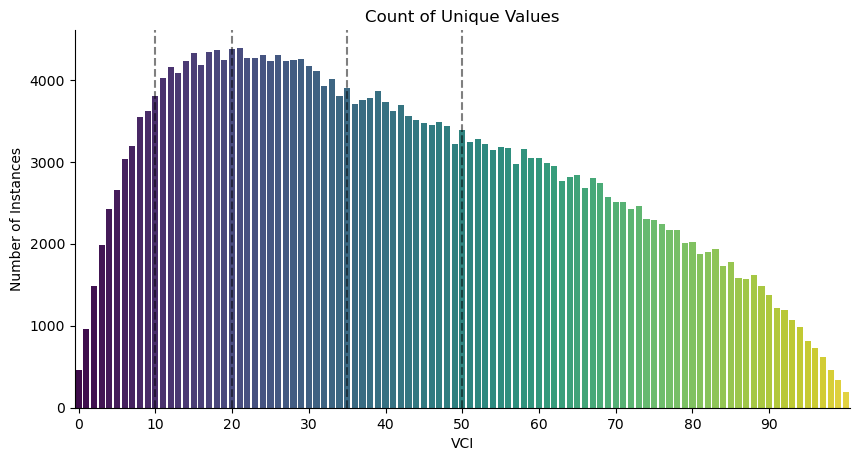

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = plot_unique_value_counts(np.round(ds[TARGET_VAR]), label=False, ax=ax)

ax.set_xlabel('VCI')
ax.axvline(10, ls='--', c='k', alpha=0.5)
ax.axvline(20, ls='--', c='k', alpha=0.5)
ax.axvline(35, ls='--', c='k', alpha=0.5)
ax.axvline(50, ls='--', c='k', alpha=0.5)

ax.set_xticks(np.arange(0, 100, 10))
ax.set_xticklabels(np.arange(0, 100, 10));

# Load in model predictions

In [12]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1]# .where(~mask)
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1]# .where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1]#.where(~mask)
lr_pred = read_pred_data('linear_regression', data_dir, experiment=EXPERIMENT)[-1]#.where(~mask)
ln_pred = read_pred_data('linear_network', data_dir, experiment=EXPERIMENT)[-1]#.where(~mask)

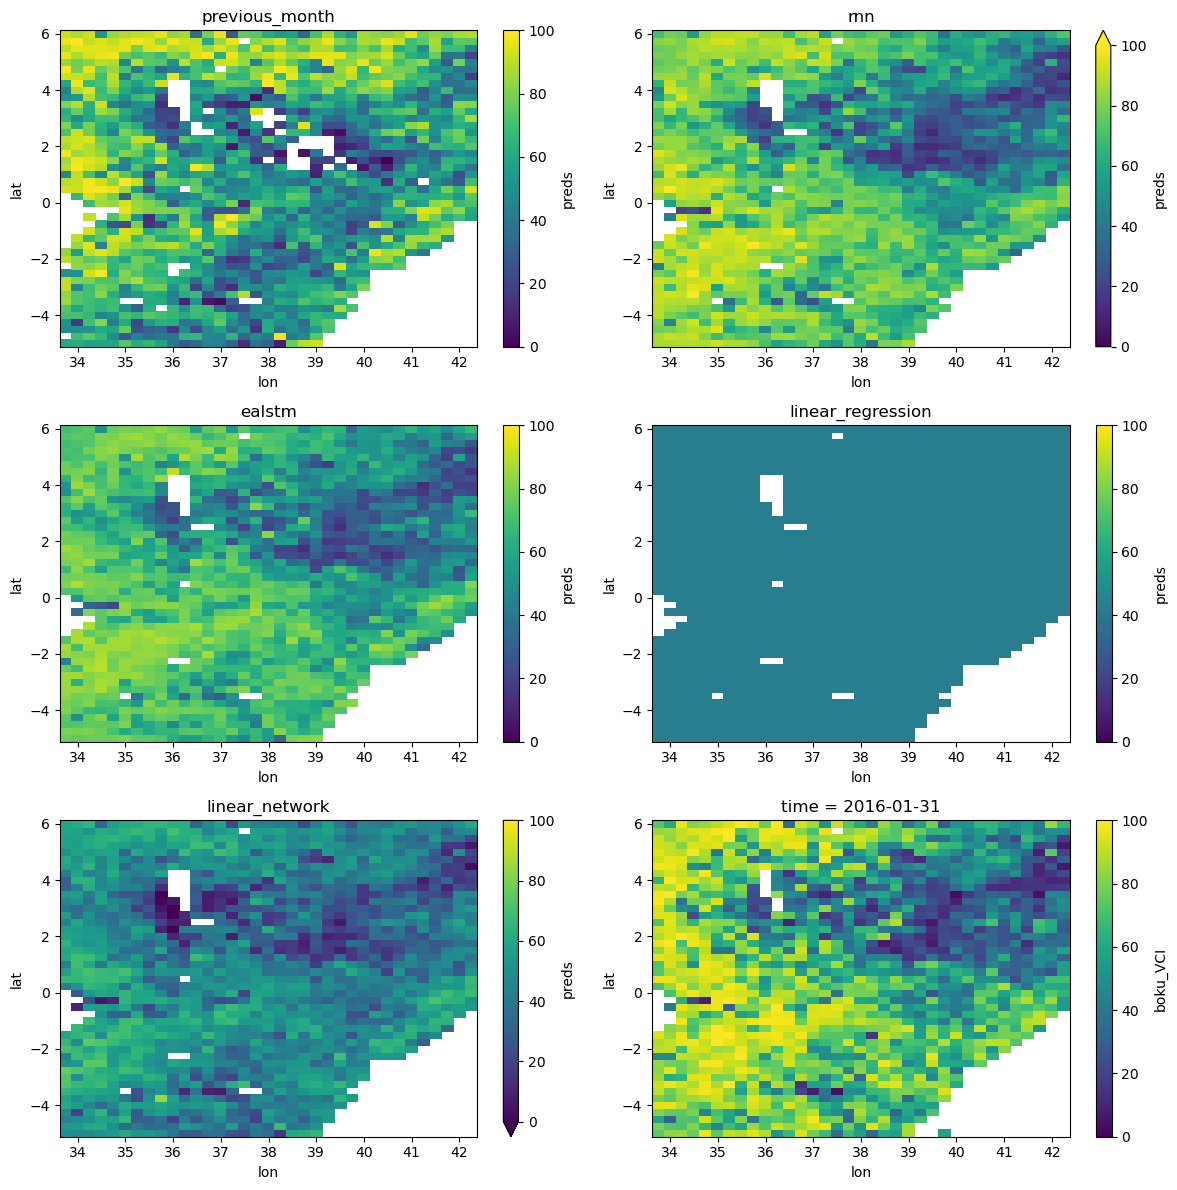

In [13]:
preds_dict = {"previous_month": bline_pred, 
"rnn": lstm_pred, 
"ealstm": ealstm_pred, 
"linear_regression": lr_pred, 
"linear_network": ln_pred}

fig, axs = plt.subplots(3, 2, figsize=(6*2, 4*3))

for ix, (model_name, preds) in enumerate(preds_dict.items()):
    ax = axs[np.unravel_index(ix, (3,2))]
    preds.isel(time=0).plot(ax=ax, vmin=0, vmax=100, cmap='viridis')
    ax.set_title(model_name)


ax = axs[np.unravel_index(5, (3,2))]
y_test[TARGET_VAR].isel(time=0).plot(ax=ax, vmin=0, vmax=100, cmap='viridis')
    
fig.tight_layout()

# DataFrame of Model Performances

In [14]:
from src.analysis import annual_scores

In [15]:
[d.name for d in (data_dir / f"models/{EXPERIMENT}").iterdir()]

['rnn', 'linear_network', 'previous_month', 'ealstm', 'linear_regression']

In [16]:
models = ['ealstm', 'rnn', 'previous_month', 'linear_network', 'linear_regression']

# load the monthly scores dictionary
monthly_scores = annual_scores(
    data_path=data_dir,
    models=models,
    metrics=['rmse', 'r2'],
    pred_years=[y for y in range(2016, 2019)],
    experiment=EXPERIMENT,
    true_data_experiment=TRUE_EXPERIMENT,
    target_var=TARGET_VAR,
    verbose=False,
    to_dataframe=True
)
monthly_scores['time'] = monthly_scores.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)
monthly_scores.head()

,month,year,ealstm,rnn,previous_month,linear_network,linear_regression,metric,time
0,1.0,2016.0,13.438398,12.590804,21.886197,25.585350,32.801580,rmse,2016-01-01
1,2.0,2016.0,12.493573,12.581519,21.712380,20.808718,26.914791,rmse,2016-02-01
2,3.0,2016.0,14.505330,14.713287,17.362805,28.726431,24.062409,rmse,2016-03-01
3,4.0,2016.0,12.044819,10.667603,15.724187,14.180259,20.576316,rmse,2016-04-01
4,5.0,2016.0,13.917147,13.281613,17.737472,14.789164,20.688625,rmse,2016-05-01


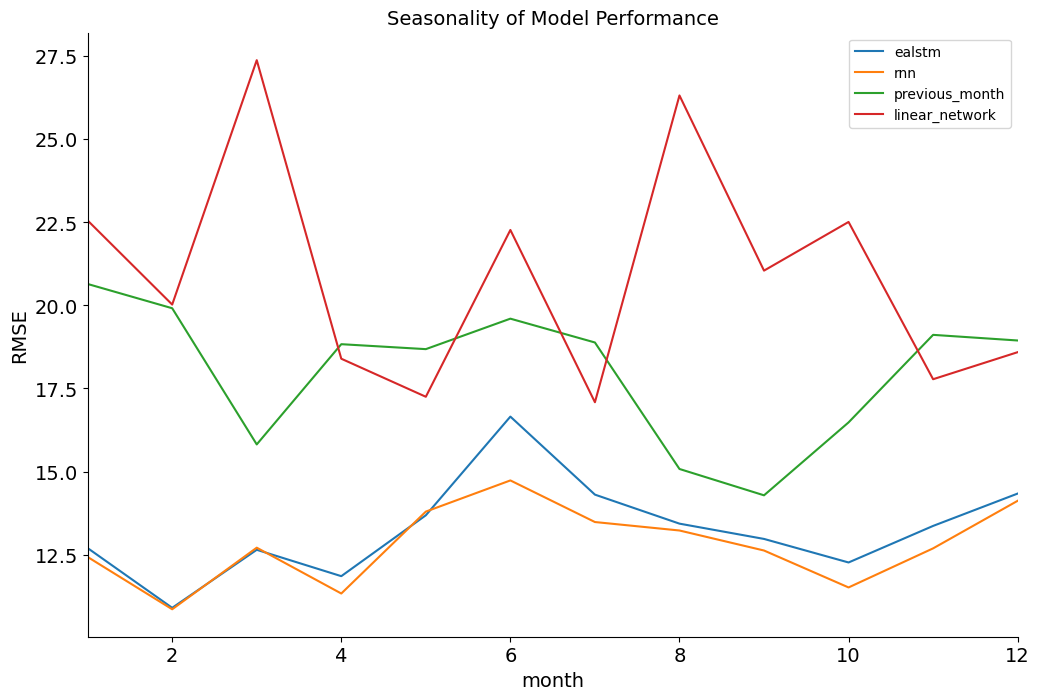

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

metric = 'rmse'

models2 = ['ealstm', 'rnn', 'previous_month', 'linear_network', ]
for model in models2:
    (
        monthly_scores
        .where(monthly_scores.metric == metric)
        .groupby('month').mean().reset_index()
        .plot(x='month', y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Seasonality of Model Performance')
ax.set_ylabel(metric.upper());
ylim = (0, 15) if TARGET_VAR == "VCI3M" else ax.get_ylim()
ax.set_ylim(ylim)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



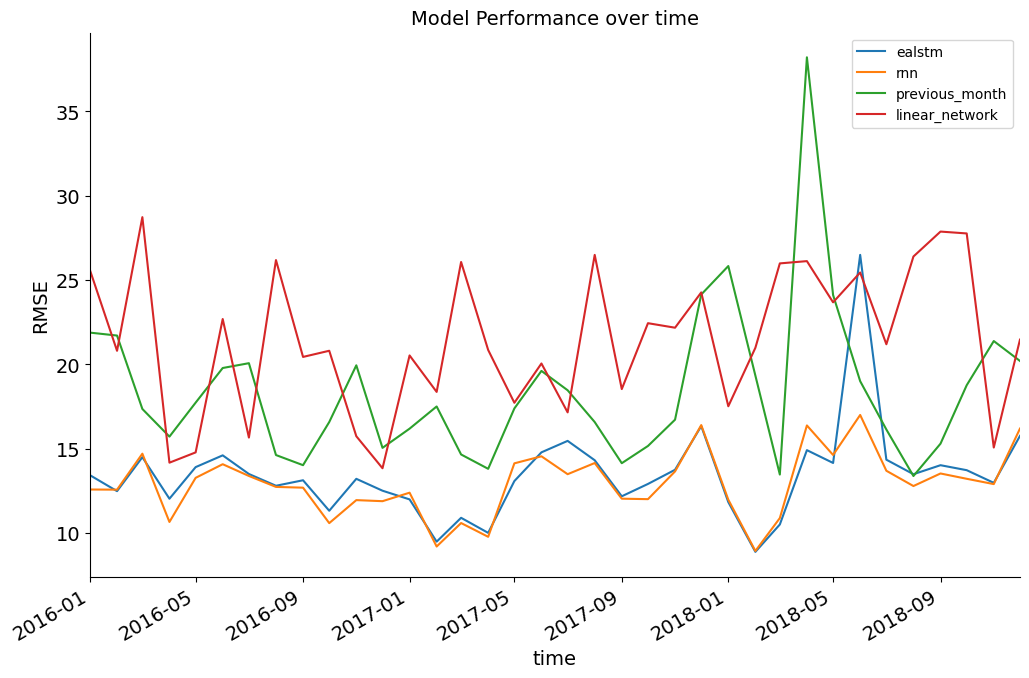

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in models2: # 
    (
        monthly_scores
        .where(monthly_scores.metric == metric)
        .set_index('time')
        .plot(y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Model Performance over time')
ax.set_ylabel(metric.upper());

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Explore Temporal Errors

In [19]:
def calculate_error(true_da, pred_da, method=None):
    if method == 'squared':
        vals = (true_da.values - pred_da.values) ** 2
    elif method == 'absolute':
        vals = abs((true_da.values - pred_da.values))
    else:
        vals = (true_da.values - pred_da.values)
    da = xr.ones_like(true_da) * vals
    return da.rename(f'{method + "_" if method is not None else ""}error')


ealstm_error = calculate_error(
    pred_da=ealstm_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)
lstm_error = calculate_error(
    pred_da=lstm_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)
bline_error = calculate_error(
    pred_da=bline_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)
lr_error = calculate_error(
    pred_da=lr_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)
ln_error = calculate_error(
    pred_da=ln_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)

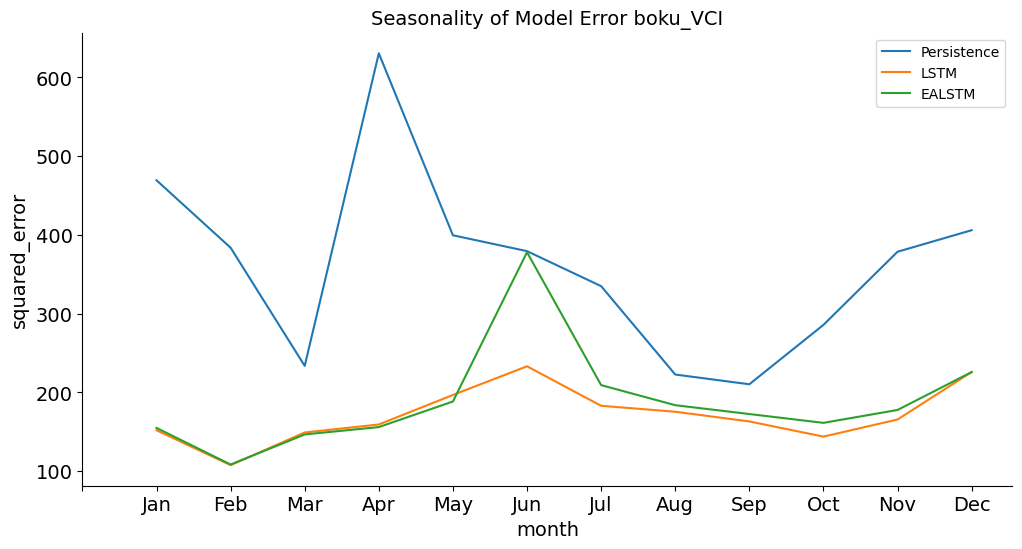

In [20]:
import calendar 
mths = [m for m in calendar.month_abbr]
fig, ax = plt.subplots(figsize=(12, 6))

bline_error.groupby('time.month').mean(dim=['time']).mean(dim=['lat', 'lon']).plot(ax=ax, label='Persistence')
lstm_error.groupby('time.month').mean(dim=['time']).mean(dim=['lat', 'lon']).plot(ax=ax, label='LSTM')
ealstm_error.groupby('time.month').mean(dim=['time']).mean(dim=['lat', 'lon']).plot(ax=ax, label='EALSTM')
plt.legend()

ax.set_title(f'Seasonality of Model Error {TARGET_VAR}', size=16);
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
ax.set_ylabel(bline_error.name, size=14)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Explore Spatial Errors

In [21]:
from src.analysis import spatial_rmse, spatial_r2

# -------- LSTM
lstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    lstm_pred.transpose("time", "lat", "lon")
)

# -------- EALSTM
ealstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# -------- Baseline
bline_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)

# -------- Linear Network
ln_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
ln_pred.transpose("time", "lat", "lon")
)

# -------- Linear Regression
lr_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
lr_pred.transpose("time", "lat", "lon")
)


# calculate mean performance scores
lstm_mean = lstm_rmse.mean().values
ealstm_mean = ealstm_rmse.mean().values
bline_mean = bline_rmse.mean().values
lr_mean = lr_rmse.mean().values
ln_mean = ln_rmse.mean().values

print("lstm_mean RMSE: ".ljust(20), f"{lstm_mean:.2f}")
print("ealstm_mean RMSE: ".ljust(20), f"{ealstm_mean:.2f}")
print("bline_mean RMSE: ".ljust(20), f"{bline_mean:.2f}")
print("lr_mean RMSE: ".ljust(20), f"{lr_mean:.2f}")
print("ln_mean RMSE: ".ljust(20), f"{ln_mean:.2f}")

lstm_mean RMSE:      12.87
ealstm_mean RMSE:    13.56
bline_mean RMSE:     18.69
lr_mean RMSE:        25.96
ln_mean RMSE:        21.60


In [22]:
# -------- LSTM
lstm_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    lstm_pred.transpose("time", "lat", "lon")
)

# -------- EALSTM
ealstm_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# -------- Baseline
bline_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)

# -------- Linear Network
ln_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
ln_pred.transpose("time", "lat", "lon")
)

# -------- Linear Regression
lr_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
lr_pred.transpose("time", "lat", "lon")
)


# calculate mean performance scores
lstm_mean = lstm_r2.mean().values
ealstm_mean = ealstm_r2.mean().values
bline_mean = bline_r2.mean().values
lr_mean = lr_r2.mean().values
ln_mean = ln_r2.mean().values

print("lstm_mean r2: ".ljust(20), f"{lstm_mean:.2f}")
print("ealstm_mean r2: ".ljust(20), f"{ealstm_mean:.2f}")
print("bline_mean r2: ".ljust(20), f"{bline_mean:.2f}")
print("lr_mean r2: ".ljust(20), f"{lr_mean:.2f}")
print("ln_mean r2: ".ljust(20), f"{ln_mean:.2f}")

lstm_mean r2:        0.73
ealstm_mean r2:      0.71
bline_mean r2:       0.44
lr_mean r2:          0.00
ln_mean r2:          0.39


# Plot CDF Comparisons of different models

In [23]:
rmses = {
    "lstm": lstm_rmse,
    "ealstm": ealstm_rmse,
    "bline": bline_rmse,
#     "lr": lr_rmse,
    "ln": ln_rmse,
}

r2s = {
    "lstm": lstm_r2,
    "ealstm": ealstm_r2,
    "bline": bline_r2,
#     "lr": lr_r2,
    "ln": ln_r2,
}

In [24]:
def plot_cdf(data: np.array, ax: Optional[plt.Axes] = None, **kwargs):
    """plot the sorted_data array against the number 
    of items smaller than each element in the array

    # https://stackoverflow.com/a/24576863/9940782
    """
    sorted_data = np.sort(data)
    sorted_data = sorted_data[~np.isnan(sorted_data)]
    
    # compute the 
    yvals = np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(sorted_data, yvals, **kwargs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    
    return ax

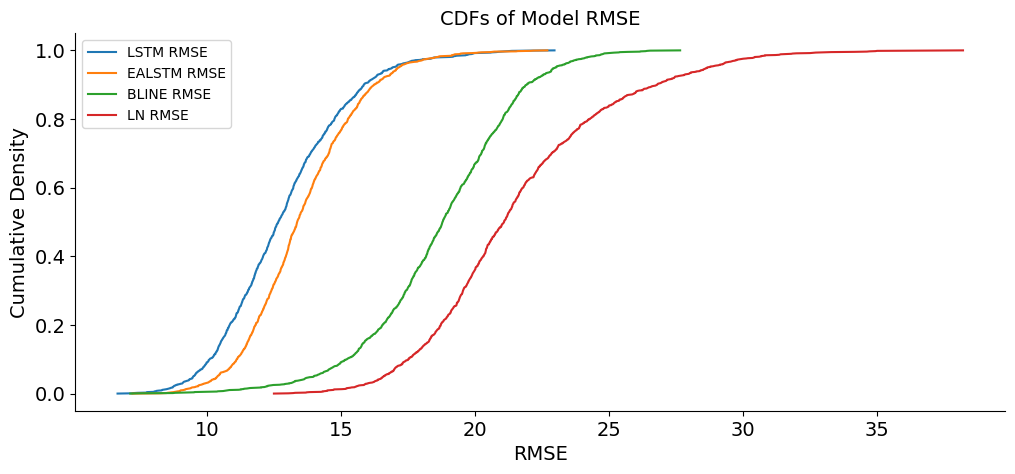

In [25]:
scale = 1
fig, ax = plt.subplots(figsize=(12*scale, 5*scale))

for model, rmse in rmses.items():
    data = rmse.values.flatten()
    plot_cdf(data, ax=ax, **dict(label=f'{model.upper()} RMSE'))

ax.set_title('CDFs of Model RMSE')
ax.set_xlabel('RMSE')
ax.set_ylabel('Cumulative Density')


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

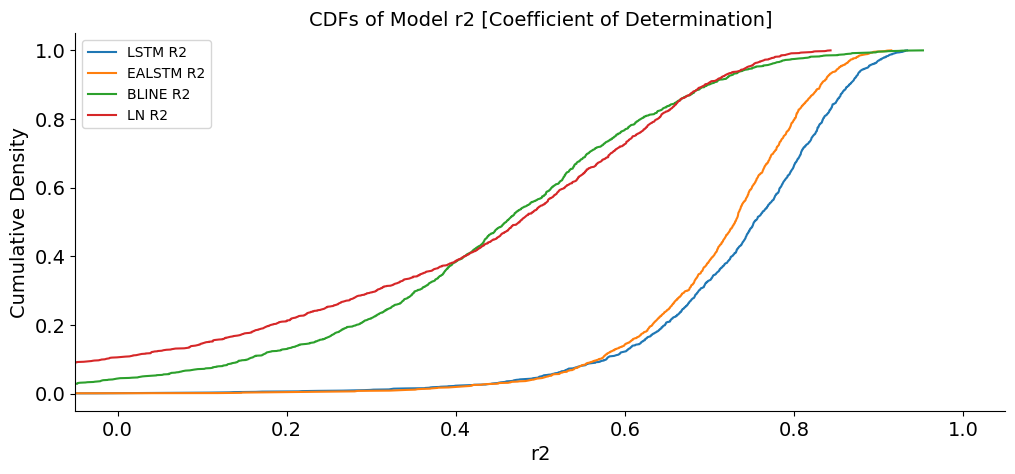

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))

for model, r2 in r2s.items():
    data = r2.values.flatten()
    plot_cdf(data, ax=ax, **dict(label=f'{model.upper()} R2'))

ax.set_title('CDFs of Model r2 [Coefficient of Determination]')
ax.set_xlabel('r2')
ax.set_ylabel('Cumulative Density')
ax.set_xlim(-0.05, 1.05)


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# How perform in different Regions

In [27]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(
    data_dir=data_dir,
    experiment=EXPERIMENT,
    true_data_experiment=TRUE_EXPERIMENT
)
r = RegionGeoPlotter(data_dir)

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['rnn', 'linear_network', 'previous_month', 'ealstm', 'linear_regression']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
The RegionGeoPlotter requires `geopandas` to be installed.
GroupbyRegion requires geopandas to be installed


In [28]:
region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

In [29]:
def get_region_mask(region: str):
    lookup = dict(zip(region_lookup.values(), region_lookup.keys()))
    region_id = lookup[region]
    
    return ~region_da.where(region_da == region_id).isnull()

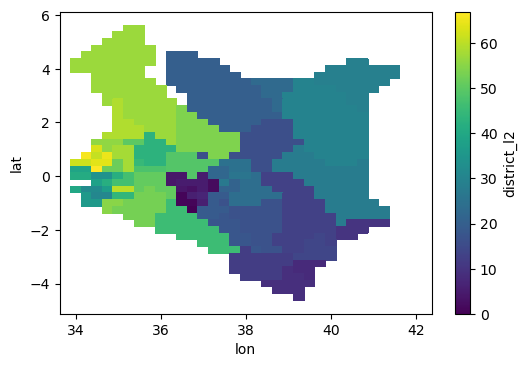

In [30]:
region_da.plot()

In [31]:
analyzer.analyze()

* Analyzing for district_l2_kenya *

** Analyzing for rnn-district_l2_kenya **
** Written rnn csv to data/analysis/region_analysis/rnn/rnn_district_l2_kenya.csv **

** Analyzing for linear_network-district_l2_kenya **
** Written linear_network csv to data/analysis/region_analysis/linear_network/linear_network_district_l2_kenya.csv **

** Analyzing for previous_month-district_l2_kenya **
** Written previous_month csv to data/analysis/region_analysis/previous_month/previous_month_district_l2_kenya.csv **

** Analyzing for ealstm-district_l2_kenya **
** Written ealstm csv to data/analysis/region_analysis/ealstm/ealstm_district_l2_kenya.csv **

** Analyzing for linear_regression-district_l2_kenya **
** Written linear_regression csv to data/analysis/region_analysis/linear_regression/linear_regression_district_l2_kenya.csv **
* Assigned all region dfs to `self.df` *

* Assigned Global Error Metrics to `self.global_mean_metrics` *
* Written csv to data/analysis/region_analysis/global_error_me

In [32]:
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
df = analyzer.df.copy()
df = df.set_index('datetime')
df = df.rename(columns={"true_mean_value": TARGET_VAR, "predicted_mean_value": "preds"})

gdf = region_plotter.gdf

all_gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
all_gdf.head()

GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,rnn,2016-01-31,VIHIGA,88.153908,80.547214,VIHIGA,POLYGON ((34.90335473150635 0.1988489371060185...
1,district_l2_kenya,ealstm,2016-01-31,VIHIGA,76.331573,80.547214,VIHIGA,POLYGON ((34.90335473150635 0.1988489371060185...
2,district_l2_kenya,previous_month,2016-01-31,VIHIGA,87.837838,80.547214,VIHIGA,POLYGON ((34.90335473150635 0.1988489371060185...
3,district_l2_kenya,linear_regression,2016-01-31,VIHIGA,42.042133,80.547214,VIHIGA,POLYGON ((34.90335473150635 0.1988489371060185...
4,district_l2_kenya,linear_network,2016-01-31,VIHIGA,63.365185,80.547214,VIHIGA,POLYGON ((34.90335473150635 0.1988489371060185...


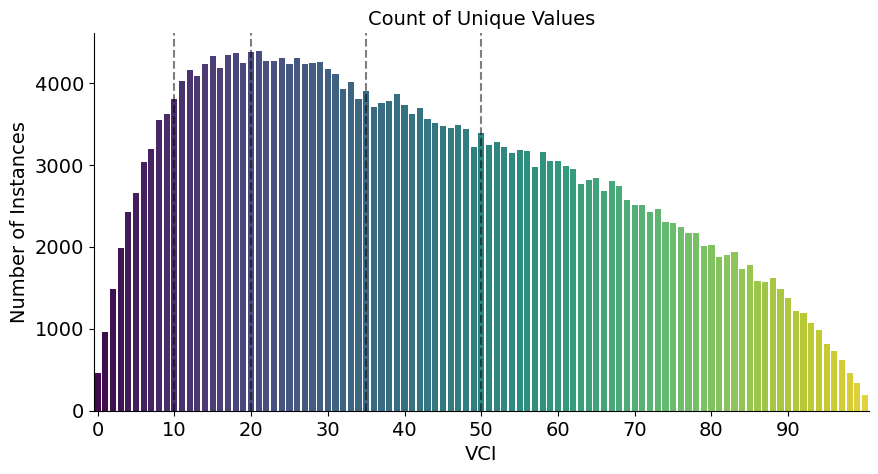

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = plot_unique_value_counts(np.round(ds[TARGET_VAR]), label=False, ax=ax)

ax.set_xlabel('VCI')
ax.axvline(10, ls='--', c='k', alpha=0.5)
ax.axvline(20, ls='--', c='k', alpha=0.5)
ax.axvline(35, ls='--', c='k', alpha=0.5)
ax.axvline(50, ls='--', c='k', alpha=0.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

ax.set_xticks(np.arange(0, 100, 10))
ax.set_xticklabels(np.arange(0, 100, 10));

# timeseries

In [34]:
pixel_ix = 10
lat, lon = y_test.stack(pixel=['lat', 'lon']).isel(pixel=pixel_ix).pixel.values.reshape(-1, )[0]

In [35]:
# plt.subplots(len(d_vars), figsize=(6, 1*d_vars))

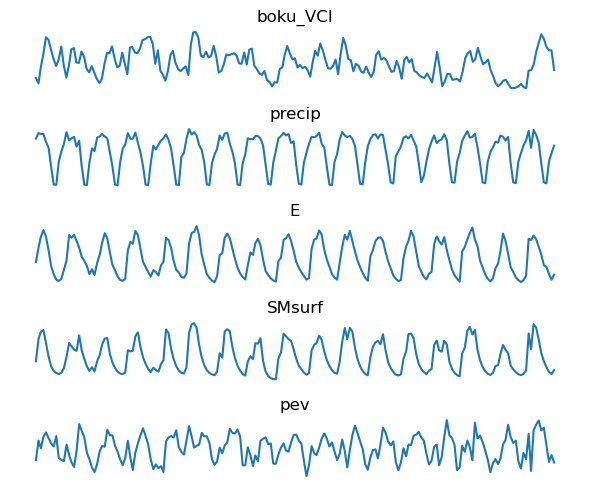

In [36]:
d_vars = [d for d in dynamic_ds.data_vars]

fig, axs = plt.subplots(len(d_vars), 1, figsize=(6, 1*len(d_vars)))

var = 'precip'

for ix, var in enumerate(d_vars):
    ax = axs[ix]
    dynamic_ds[var].sel(lat=lat, lon=lon).plot(ax=ax)
    ax.set_title(var)

    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.axis('off')
    
plt.tight_layout()

# plot the forecasts

In [37]:
# from scripts.drafts.plot_ts_scatter import plot_area_scatter, plot_timeseries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, Any, List

def plot_area_scatter(
    df: pd.DataFrame, 
    region: str,
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    target_var: str = 'VCI3M',
    region_name: Optional[str] = None,
    area_col_str: str = 'region_name',
    **kwargs,
):
    # select station
    d = df.query(f"{area_col_str} == '{region}'").drop(columns=area_col_str)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()

    # plot scatter
    if "preds" in d.columns:
        ax.plot(d[target_var], d['preds'], 'kx', alpha=0.6, label='Data Point', **kwargs)
    else:
        numeric_columns = [c for c in data_df.columns if (data_df[c].dtype == "float64") & (c != TARGET_VAR)]
        colors = sns.color_palette()[:len(numeric_columns)]
        for numeric_col, color in zip(numeric_columns, colors):
            ax.plot(d[target_var], d[numeric_col], 'kx', alpha=0.6, label=f'{numeric_col}', color=color, **kwargs)
    # plot 1:1 line
    line_1_1_x = np.linspace(d[target_var].min(), d[target_var].max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {region}' + f" {region_name}" if region_name is not None else f'Station {region}'
    ax.set_title(title)

    ax.legend();

    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax


def plot_timeseries(
    df: pd.DataFrame,
    region: str,
    metrics_df: Optional[pd.DataFrame] = None,
    ax=None,
    region_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
    area_col_str: str = 'region_name',
):
    """Plot the Observed vs. Preds for the region"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    # plot the station
    if "preds" in df.columns:
        if plot_years is None:
            df.query(f"{area_col_str} == '{region}'").drop(columns=area_col_str).plot(ax=ax)
        else:
            (
                df.loc[np.isin(df.index.year, plot_years)]
                .query(f"{area_col_str} == '{region}'")
                .drop(columns=area_col_str).plot(ax=ax)
            )
    else:
        if plot_years is None:
            df.query(f"{area_col_str} == '{region}'")[TARGET_VAR].plot(ax=ax, )
            df.query(f"{area_col_str} == '{region}'").drop(columns=[area_col_str, TARGET_VAR]).plot(ax=ax)
        else:
            (
                df.loc[np.isin(df.index.year, plot_years)]
                .query(f"{area_col_str} == '{region}'")
                .drop(columns=area_col_str).plot(ax=ax)
            )
                
    # get the error metrics
    if metrics_df is None:
        station_title = f"{region}" if region_name is not None else region
        ax.set_title(f"{station_title}")
    else:
        rmse_val = metrics_df.query(f"region == '{region}'").rmse.values[0]
        r2_val = metrics_df.query(f"region == '{region}'").r2.values[0]
        # nse_val = metrics_df.query(f"region == '{region}'").nse.values[0]
        # set the title
        station_title = f"{region} {region_name}" if region_name is not None else region
        ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")

    return fig, ax


In [38]:
# regions = all_gdf.region_name.unique()
data_df = df.copy().set_index("datetime") if "datetime" in df.columns else df.copy()
data_df = data_df.rename(columns={"true_mean_value": TARGET_VAR, "predicted_mean_value": "preds"}).drop(columns=["admin_level_name"])

m1 = data_df.reset_index().set_index(['datetime', 'region_name']).query('model == "rnn"').rename(columns={"preds": "lstm"}).drop(columns=['model'])
m2 = data_df.reset_index().set_index(['datetime', 'region_name']).query('model == "ealstm"').rename(columns={"preds": "ealstm"}).drop(columns=['model', TARGET_VAR])
data_df = m1.join(m2).reset_index().set_index('datetime')

# model = 'ealstm'
plot_years = None # [2016]
scale = 0.8
fig, axs = plt.subplots(len(regions), 2, figsize=((12*scale), (6*scale)*len(regions)))

for ix, region in enumerate(regions):
    try:
        # plot the timeseries
        plot_timeseries(
            data_df.drop(columns=TARGET_VAR),  # data_df.query(f"model == '{model}'"), 
            region, 
            metrics_df=None, 
            ax=axs[ix, 0], 
            region_name=region, 
            plot_years=plot_years
        )
        data_df.query(f"region_name=='{region}'")[TARGET_VAR].plot(ax=axs[ix, 0], c='k', label='Observed VCI', ls='--')
        axs[ix, 0].set_ylim(0, 100)
        axs[ix, 0].legend()
        
        # plot the scatterplot
        plot_area_scatter(
            data_df,  # data_df.query(f"model == '{model}'"), 
            region, 
            metrics_df=None, 
            ax=axs[ix, 1]
        )
        axs[ix, 1].set_xlim(0, 100)
        axs[ix, 1].set_ylim(0, 100)
    except TypeError:
        print(f"** {region_name} data does not exist in the predictions! **")

    plt.tight_layout()

NameError: name 'regions' is not defined

# Build the spatial maps of performance

In [ ]:
max_val = 7 if TARGET_VAR == "VCI3M" else 10

region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'ealstm').dropna(),
    **dict(rmse_vmax=max_val, mae_vmax=max_val, mae_vmin=0, rmse_vmin=0)
);
plt.gcf().suptitle('EALSTM Regional Errors', size=15)
plt.tight_layout(rect=[0, 0.03, 1, 1.25])

In [ ]:
region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'rnn').dropna(),
    **dict(rmse_vmax=max_val, mae_vmax=max_val, mae_vmin=0, rmse_vmin=0)
);
plt.gcf().suptitle('LSTM Regional Errors', size=15)
plt.tight_layout(rect=[0, 0.03, 1, 1.25])

In [ ]:
region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'previous_month').dropna(),
    **dict(rmse_vmax=max_val, mae_vmax=max_val, mae_vmin=0, rmse_vmin=0)
);
plt.gcf().suptitle('Persistence Baseline Regional Errors', size=15)
plt.tight_layout(rect=[0, 0.03, 1, 1.25])

# Plot the scatterplots of performance

In [39]:
from scripts.drafts.eng_utils import nans_mask_from_multiple_arrays



In [40]:
def get_model_yhat_y_arrays(pred_ds: xr.Dataset, ds: xr.Dataset) -> Tuple[np.ndarray, np.ndarray]:
    """"""
    target_y = ds[TARGET_VAR].sel(time=pred_ds.time)
    multimask = nans_mask_from_multiple_arrays([pred_ds, target_y])
    yhat = pred_ds.where(~multimask).values
    yhat = yhat[~np.isnan(yhat)]
    y = target_y.where(~multimask).values
    y = y[~np.isnan(y)]

    assert y.shape == yhat.shape
    return y, yhat

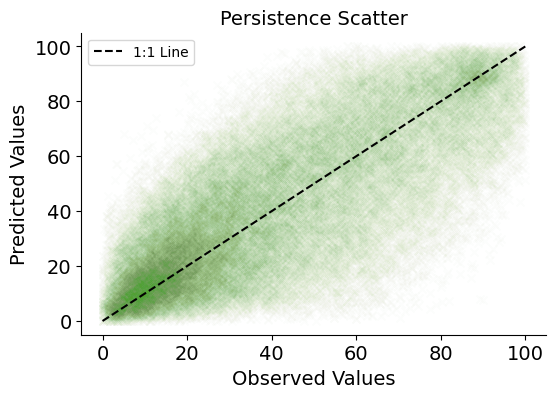

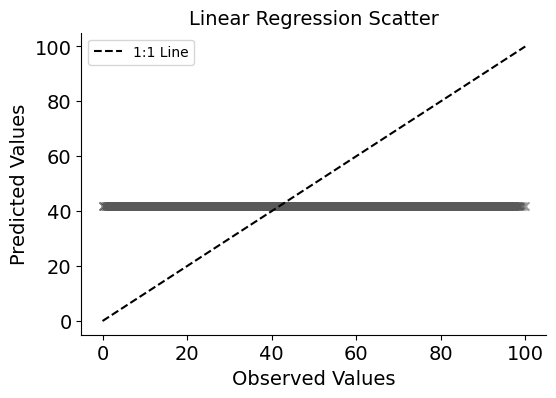

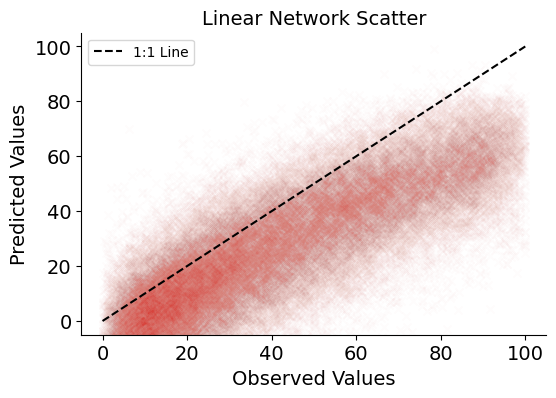

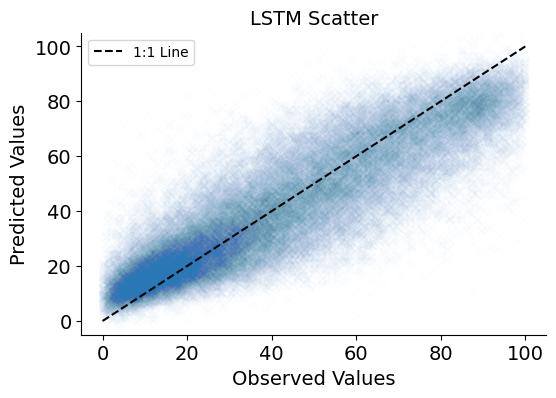

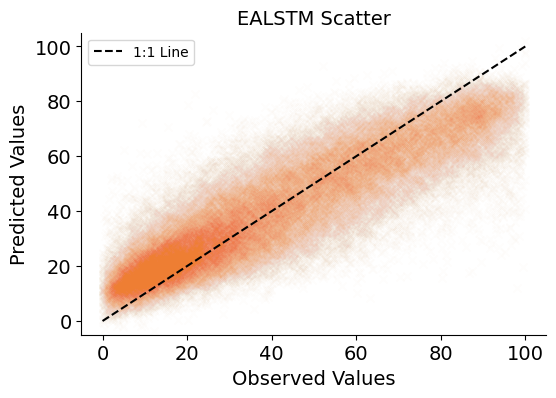

In [41]:
model_preds = [bline_pred, lr_pred, ln_pred, lstm_pred, ealstm_pred]
models = ["Persistence", "Linear Regression", "Linear Network", "LSTM", "EALSTM"]
colors = ["#52a02e", "#595959", "#d7392e", "#2977b4", "#ee7e33",]

for (model, pred_ds, color) in zip(models, model_preds, colors):
    y, yhat = get_model_yhat_y_arrays(pred_ds, ds)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(y, yhat, marker='x', c=color, alpha=0.01)

    # plot 1:1 line
    line_1_1_x = np.linspace(y.min(), y.max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    ax.set_title(f"{model} Scatter")
    ax.set_ylim(ax.get_xlim())
    ax.set_ylabel("Predicted Values")
    ax.set_xlabel("Observed Values")

    ax.legend()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Explore the autocorrelation
- [fit with multiple time series](https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/)

In [104]:
from pandas.plotting import lag_plot, autocorrelation_plot


In [105]:
ytest_df = y_test[TARGET_VAR].to_dataframe().reset_index().set_index("time")
pixel_id, pixel_label = pd.factorize(ytest_df['lat'].astype(str) + ', ' + ytest_df['lon'].astype(str))
ytest_df['pixel_id'] = pixel_id
ytest_df = ytest_df.drop(columns=["lat", "lon"])
print(ytest_df.shape)
ytest_df.head()

(56700, 2)


,boku_VCI,pixel_id
time,,
2016-01-31,74.480022,0
2016-01-31,83.209877,1
2016-01-31,84.388186,2
2016-01-31,76.114911,3
2016-01-31,97.267760,4


### tsfresh format
```python
id	time	kind	value
A	t1		x	(A, t1)
A	t2		x	(A, t2)


column_id="id", column_sort="time", column_kind="kind", column_value="value"

```

In [106]:
ts_df = ytest_df.reset_index()
ts_df["kind"] = ["y" for row in range(len(ts_df))]
ts_df = ts_df[['pixel_id', 'time', 'kind', 'boku_VCI']]

# (column_id="pixel_id", column_sort="time", column_kind="kind", column_value="boku_VCI")
ts_df.head()

,pixel_id,time,kind,boku_VCI
0,0,2016-01-31,y,74.480022
1,1,2016-01-31,y,83.209877
2,2,2016-01-31,y,84.388186
3,3,2016-01-31,y,76.114911
4,4,2016-01-31,y,97.267760


### numpy format
X, y

### long format
```
 -------------------------
| time | pixel0 | pixel1 | ...
| ------------------------
| t1   |  value |  value | 

```

In [57]:
d = ytest_df.reset_index()
long_format = d.set_index(['pixel_id', 'time']).unstack('pixel_id')
long_format.head(1)

boku_VCI                                                        \
pixel_id         0          1          2          3         4          5      
time                                                                          
2016-01-31  74.480022  83.209877  84.388186  76.114911  97.26776  75.384615   

                                                        ...             \
pixel_id         6          7          8          9     ...       1565   
time                                                    ...              
2016-01-31  91.380477  87.953139  95.555556  87.922705  ...  49.491432   

                                                                             \
pixel_id        1566       1567       1568       1569       1570       1571   
time                                                                          
2016-01-31  50.02451  65.447885  65.079365  56.439526  47.011252  55.565979   

                                            
pixel_id         1572       1573      1574  
time                                        
2016-01-31  42.875914  84.399732  66.31391  

[1 rows x 1575 columns]

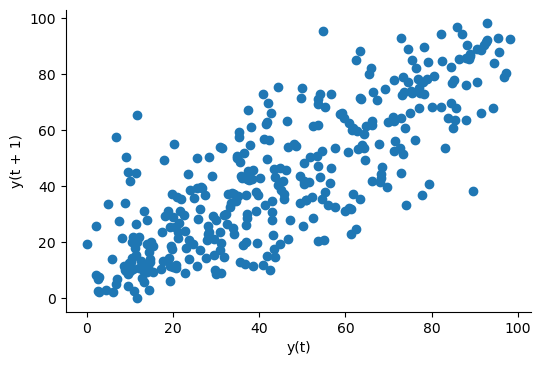

In [62]:
fig, ax = plt.subplots()

for i in range(10):
    lag_plot(long_format.iloc[:, i], ax=ax)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

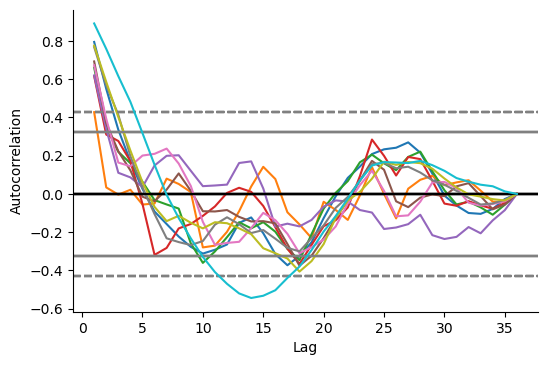

In [66]:
fig, ax = plt.subplots()

for i in range(10):
    autocorrelation_plot(long_format.iloc[:, i], ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Fit an autoregressive model
- https://www.statsmodels.org/dev/examples/notebooks/generated/autoregressions.html#Forecasting
-

In [88]:
from statsmodels.tsa.ar_model import AR
import statsmodels.api as sm

In [69]:
?AR

Init signature: AR(endog, dates=None, freq=None, missing='none')
Docstring:     
Autoregressive AR(p) model

Parameters
----------
endog : array-like
    1-d endogenous response variable. The independent variable.
dates : array-like of datetime, optional
    An array-like object of datetime objects. If a pandas object is given
    for endog or exog, it is assumed to have a DateIndex.
freq : str, optional
    The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
    'M', 'A', or 'Q'. This is optional if dates are given.
missing : str
    Available options are 'none', 'drop', and 'raise'. If 'none', no nan
    checking is done. If 'drop', any observations with nans are dropped.
    If 'raise', an error is raised. Default is 'none.'
File:           /opt/conda/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py
Type:           type
Subclasses:     


In [91]:
data = ytest_df.query("pixel_id==0").drop(columns='pixel_id')
ar = AR(data, freq='M')
ar = ar.fit()

In [97]:
print('The lag value chosen is: %s' % ar.k_ar)
print('The coefficients of the model are:\n %s' % ar.params)

The lag value chosen is: 9
The coefficients of the model are:
 const          13.484268
L1.boku_VCI     0.871584
L2.boku_VCI     0.005190
L3.boku_VCI    -0.262499
L4.boku_VCI     0.004233
L5.boku_VCI     0.231863
L6.boku_VCI    -0.093728
L7.boku_VCI    -0.088971
L8.boku_VCI    -0.005705
L9.boku_VCI    -0.112849
dtype: float64


In [94]:
model = sm.tsa.SARIMAX(endog=data, order=(3, 0, 0))
model = model.fit()

In [95]:
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:               boku_VCI   No. Observations:                   36
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -144.706
Date:                Mon, 11 May 2020   AIC                            297.413
Time:                        10:58:27   BIC                            303.747
Sample:                    01-31-2016   HQIC                           299.624
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0712      0.196      5.479      0.000       0.688       1.454
ar.L2         -0.1168      0.243     -0.481      0.631      -0.593       0.359
ar.L3       3.786e-05      0.193      0.000      1.0

In [1]:
# ?sm.tsa.SARIMAX